In [1]:
## Plot GPS on top of InSAR data and Save GPS to text file for GEODMOD

import os
import numpy as np
import matplotlib.pyplot as plt
from pysar.simulation.plot import *
from pysar.objects.gps import search_gps, GPS
from pysar.objects import sensor
from pysar.utils import utils as ut
from pysar import view

# input
date12 = '20180706_20180712'
work_dir = os.path.expandvars('$INSAR_HOME/test/FALK/modelGalapagosSenAT106/')

os.chdir(work_dir)
print('Go to directory', work_dir)

# files used
ifgram_file = 'geo_ifgramStack.h5'
vel_file = 'geo_velocity.h5'
geom_file = 'geo_geometryRadar.h5'
water_mask_file = 'waterMask.h5'   # generated with generate_mask.py geo_geometryRadar.h5 height -m 3.5 -o waterMask.h5 option

print_msg = False
start_date, end_date = date12.split('_')
proj_name = sensor.project_name2sensor_name(work_dir)[1]

# output files
txt_file = os.path.join(work_dir, 'GPS_{}_{}.txt'.format(proj_name, date12))
fig_file = os.path.join(work_dir, '{}_{}_insar_gps.png'.format(proj_name, date12))

Go to directory /Users/yunjunz/insarlab/test/FALK/modelGalapagosSenAT106/


In [2]:
## Configuration for InSAR background: check view.py -h for more plotting options.
cmd = 'view.py {} unwrapPhase-{} -m {} -d {} '.format(ifgram_file, date12, water_mask_file, geom_file)
cmd += '--sub-lat -0.87 -0.77 --sub-lon -91.20 -91.08 '
cmd += '--notitle -u cm -c jet_r --nocbar --lalo-label --lalo-max-num 3 '
dv, atr, inps = view.prep_slice(cmd, print_msg=print_msg)

In [3]:
## Get GPS data
rerun = False
if rerun or not os.path.isfile(txt_file):
    # 1. find available GPS
    print('searching available GPS')
    SNWE = (inps.geo_box[3], inps.geo_box[1],
            inps.geo_box[0], inps.geo_box[2])
    site_names, site_lats, site_lons = search_gps(SNWE, inps.gps_start_date, inps.gps_end_date)
    num_site = len(site_names)

    # 2. get GPS displacement
    print('reading GPS displacement between {} and {} ...'.format(start_date, end_date))
    gps_dis, gps_lats, gps_lons, gps_names = [], [], [], []
    for i in range(num_site):
        obj = GPS(site_names[i])
        dis0 = np.array(obj.read_displacement(start_date, start_date, print_msg=print_msg)[1:]) * 100.
        dis1 = np.array(obj.read_displacement(end_date,   end_date,   print_msg=print_msg)[1:]) * 100.
        if all(i[0].size != 0 for i in [dis0, dis1]):
            dis = dis1 - dis0
            dis[3:] = (dis1[3:]**2 + dis0[3:]**2)**0.5
            gps_dis.append(dis)
            gps_lats.append(site_lats[i])
            gps_lons.append(site_lons[i])
            gps_names.append(site_names[i])
    gps_dis = np.squeeze(np.array(gps_dis))
    gps_lats = np.array(gps_lats)
    gps_lons = np.array(gps_lons)
    gps_names = np.array(gps_names)

    # 3. Save GPS data to text file in GEODMOD format
    f = open(txt_file, 'w')
    f.write('#Site   lat/deg     lon/deg    Nvel/cm    Nerr/cm   Evel/cm   Nerr/cm   Uvel/cm   Uerr/cm\n')
    for i in range(len(gps_names)):
        fmt = '  '.join(['{}'] + ['{:10.05f}']*2 + ['{:8.2f}']*6)
        line = fmt.format(gps_names[i],
                          gps_lats[i], gps_lons[i],
                          gps_dis[i,1], gps_dis[i,4],
                          gps_dis[i,0], gps_dis[i,3],
                          gps_dis[i,2], gps_dis[i,5])
        f.write(line+'\n')
    f.close()
    print('saved GPS data to text file:', os.path.join(os.getcwd(),txt_file))

# read GPS data from text file
fc = np.loadtxt(txt_file, dtype=bytes).astype(str)
gps_names = fc[:,0]
gps_lats = fc[:,1].astype(np.float)
gps_lons = fc[:,2].astype(np.float)
dis_n = fc[:,3].astype(np.float).reshape(-1,1)
dis_e = fc[:,5].astype(np.float).reshape(-1,1)
dis_u = fc[:,7].astype(np.float).reshape(-1,1)
print('read GPS data from file:', txt_file)

read GPS data from file: /Users/yunjunz/insarlab/test/FALK/modelGalapagosSenAT106/GPS_modelGalapagosSenAT106_20180706_20180712.txt


saved to file /Users/yunjunz/insarlab/test/FALK/modelGalapagosSenAT106/modelGalapagosSenAT106_20180706_20180712_insar_gps.png


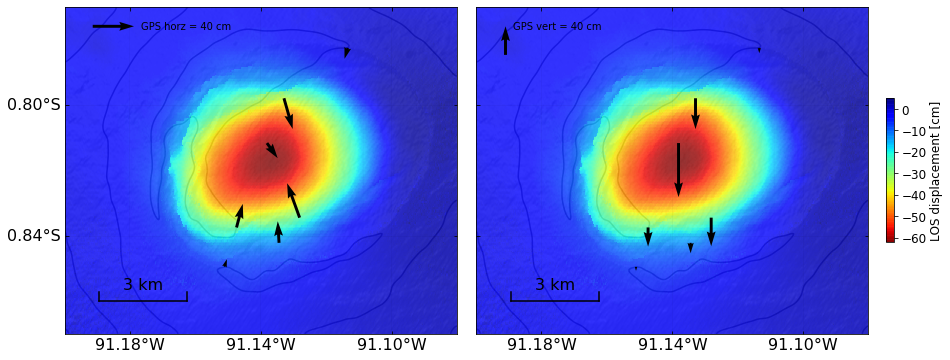

In [4]:
## Plot GPS on top of InSAR
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12, 5], sharey=True)

key_length = np.median(np.hstack((np.abs(dis_u), np.abs(np.sqrt(dis_e**2 + dis_n**2)))))
key_length = 2. * ut.round_to_1(key_length)
# Horizontal
ax = axs[0]
inps.lalo_loc = [1,0,0,1]
ax, inps, im = view.plot_slice(ax, dv, atr, inps, print_msg=print_msg)[0:3]
q  = ax.quiver(gps_lons, gps_lats, dis_e, dis_n, zorder=10, units='width', pivot='tail')
ax.quiverkey(q, X=0.1, Y=0.9, U=key_length, label='GPS horz = {:.0f} {}'.format(key_length, inps.disp_unit), labelpos='E', coordinates='figure')
# Vertical
ax = axs[1]
inps.lalo_loc = [0,0,0,1]
ax, inps, im = view.plot_slice(ax, dv, atr, inps, print_msg=print_msg)[0:3]
q  = ax.quiver(gps_lons, gps_lats, np.zeros(len(gps_lats)), dis_u, zorder=10, units='width', pivot='tail')
ax.quiverkey(q, X=0.53, Y=0.9, U=key_length, label='GPS vert = {:.0f} {}'.format(key_length, inps.disp_unit), angle=90, labelpos='E', coordinates='figure')

# InSAR colorbar
fig.subplots_adjust(left=0.02, right=0.95, bottom=0.02, top=0.98, wspace=0.05, hspace=0.05)
cax = fig.add_axes([0.97, 0.3, 0.01, 0.4])
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('LOS displacement [{}]'.format(inps.disp_unit), fontsize=font_size)

# save
plt.savefig(fig_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', fig_file)
plt.show()